2025-12-11 22:20:02.460328: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-11 22:20:02.475637: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-11 22:20:03.007189: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-11 22:20:06.030125: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

🎲 Randomly selected test image: img_0035.jpg
Loading Model...


2025-12-11 22:20:07.379348: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model loaded successfully!

--- STARTING ANALYSIS ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step
DEBUG: Model Output Stats -> Max: 0.7855, Mean: 0.0065


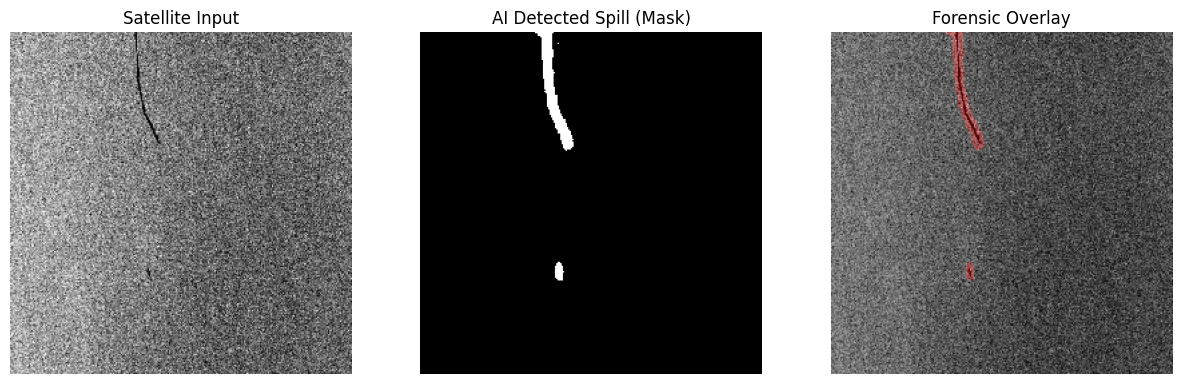


--- DAMAGE ASSESSMENT REPORT ---
Detected Oil Pixels: 804
Estimated Spill Area:  0.0804 sq. km
Oil Spill Coverage:    1.23% of Image Area
Average AI Confidence: 32.60% (in detected spill area)
SEVERITY: MODERATE - Minor leakage detected. Monitor closely.

🚢 NEARBY VESSEL ACTIVITY REPORT (AIS DATA)
Analysis Location: Lat 28.5, Lon -90.5
           Status          Vessel Name      MMSI  Speed (knots)
STOPPED (SUSPECT)      OCEAN BLACKHAWK 538005061            0.0
STOPPED (SUSPECT) DISCOVERER INSPIRATI 538002878            0.0
STOPPED (SUSPECT)               PETITE 366874110            0.0
STOPPED (SUSPECT) DISCOVERER INSPIRATI 538002878            0.0
STOPPED (SUSPECT)       NOBLE  VALIANT 538010623            0.0
STOPPED (SUSPECT)              HOUSTON 367663150            0.0
STOPPED (SUSPECT)    NOBLE FAYE KOZACK 636015856            0.0
STOPPED (SUSPECT)    NOBLE FAYE KOZACK 636015856            0.0
STOPPED (SUSPECT)             ENSCO 75 636014663            0.0
STOPPED (SUSPECT)    

In [1]:
# 3_Final_Inference.ipynb

import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import random
from tensorflow.keras.models import load_model

# --- 1. CONFIGURATION ---
MODEL_PATH = '../saved_models/unet_oil_spill.h5' 
AIS_DATA_PATH = '../data/ais_data/vessel_data_clean.csv' 

# AUTOMATICALLY FIND A RANDOM TEST IMAGE
TEST_DIR = '../data/test/images' 
TEST_IMG_PATH = None

if os.path.exists(TEST_DIR):
    # Get all files
    files = os.listdir(TEST_DIR)
    
    # Filter to ensure we only pick images (jpg, png, etc.)
    valid_extensions = {".jpg", ".jpeg", ".png", ".bmp"}
    images = [f for f in files if os.path.splitext(f)[1].lower() in valid_extensions]

    if len(images) > 0:
        # Use random.choice() to pick a different image every time
        selected_file = random.choice(images)
        TEST_IMG_PATH = os.path.join(TEST_DIR, selected_file)
        print(f"🎲 Randomly selected test image: {selected_file}")
    else:
        print("WARNING: No valid images found in '../data/test/images'. Please add one!")
        TEST_IMG_PATH = 'dummy_path.jpg'
else:
    print(f"Error: Directory {TEST_DIR} does not exist.")
    TEST_IMG_PATH = 'dummy_path.jpg' 

# --- 2. LOAD MODEL ---
print("Loading Model...")
try:
    model = load_model(MODEL_PATH)
    print("Model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")
    print("Did you run '1_UNet_Training.ipynb' to generate the .h5 file?")

# --- 3. PREDICT FUNCTION (VISION) ---
# MODIFICATION: Return raw_pred so it can be used for confidence calculation in assess_damage
def predict_spill(image_path):
    if not os.path.exists(image_path):
        print(f"Error: Image not found at {image_path}")
        # Return zeros for mask and raw_pred
        return np.zeros((256,256,3)), np.zeros((256,256,1)), np.zeros((256,256,1)) 

    # Preprocess
    original_img = cv2.imread(image_path)
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    
    img = cv2.resize(original_img, (256, 256))
    # Normalize (Crucial step)
    img_input = np.expand_dims(img, axis=0) / 255.0 
    
    # Predict
    raw_pred = model.predict(img_input)[0]
    
    # Debugging Statistics
    print(f"DEBUG: Model Output Stats -> Max: {np.max(raw_pred):.4f}, Mean: {np.mean(raw_pred):.4f}")

    # Thresholding: Reduced to 0.05 to capture low-confidence spills
    mask_pred = (raw_pred > 0.05).astype(np.uint8) 
    
    # MODIFICATION: Return raw_pred for later confidence calculation
    return img, mask_pred, raw_pred

# --- 4. ANOMALY DETECTION (DATA LOGIC) ---
def detect_anomaly(ais_csv, spill_lat, spill_lon, search_radius=0.5):
    """
    Returns a list of dictionaries containing vessel data for clean reporting.
    """
    if not os.path.exists(ais_csv):
        print("Error: AIS CSV file not found. Run '0_Prepare_AIS.py' first.")
        return []

    df = pd.read_csv(ais_csv)
    
    nearby_ships = df[
        (df['LAT'] > spill_lat - search_radius) & 
        (df['LAT'] < spill_lat + search_radius) & 
        (df['LON'] > spill_lon - search_radius) & 
        (df['LON'] < spill_lon + search_radius)
    ]
    
    report_data = []
    
    if nearby_ships.empty:
        return []
    else:
        for index, ship in nearby_ships.iterrows():
            speed = ship['SOG']
            mmsi = ship['MMSI']
            name = str(ship['VesselName'])
            
            # Determine status based on speed
            if speed < 1.0: 
                status = "STOPPED (SUSPECT)"
            else:
                status = "MOVING"
            
            # Append structured data
            report_data.append({
                "Vessel Name": name,
                "MMSI": mmsi,
                "Speed (knots)": speed,
                "Status": status
            })
            
    return report_data

# --- 5. DAMAGE ASSESSMENT (MODIFIED) ---
# MODIFICATION: Accept raw_pred argument for confidence calculation
def assess_damage(mask, raw_pred):
    # 1. Count the number of white pixels (Oil)
    oil_pixel_count = np.count_nonzero(mask)
    
    # --- CALCULATE CONFIDENCE ---
    # Only consider prediction values where a spill was actually detected (mask > 0)
    if oil_pixel_count > 0:
        # Flatten and filter raw predictions where the mask is 1
        spill_probabilities = raw_pred[mask > 0]
        # Calculate the average probability (confidence) for the detected spill area
        avg_confidence = np.mean(spill_probabilities) * 100
        # Calculate overall spill coverage percentage (as before)
        total_pixels = mask.shape[0] * mask.shape[1]
        spill_percentage = (oil_pixel_count / total_pixels) * 100
    else:
        # If no spill detected, all metrics are zero
        avg_confidence = 0.0
        spill_percentage = 0.0
    # -----------------------------
    
    # 2. Calculate Area based on Satellite Resolution
    # Assumption: Sentinel-1 imagery is approx 10m x 10m per pixel (100 sq meters)
    pixel_area_sq_m = 100 
    
    total_area_m2 = oil_pixel_count * pixel_area_sq_m
    
    # 3. Convert to Square Kilometers
    total_area_km2 = total_area_m2 / 1_000_000
    
    print("\n--- DAMAGE ASSESSMENT REPORT ---")
    print(f"Detected Oil Pixels: {oil_pixel_count}")
    print(f"Estimated Spill Area:  {total_area_km2:.4f} sq. km")
    # --- PRINT NEW PERCENTAGE AND CONFIDENCE ---
    print(f"Oil Spill Coverage:    {spill_percentage:.2f}% of Image Area")
    print(f"Average AI Confidence: {avg_confidence:.2f}% (in detected spill area)")
    # --------------------------

    # 4. Define Severity Levels
    if total_area_km2 > 1.0:
        print("SEVERITY: CRITICAL - Large scale cleanup required immediately.")
    elif total_area_km2 > 0.1:
        print("SEVERITY: HIGH - Containment booms advised.")
    elif total_area_km2 > 0.0:
        print("SEVERITY: MODERATE - Minor leakage detected. Monitor closely.")
    else:
        print("SEVERITY: NONE - No oil detected.")

# --- 6. RUN PIPELINE (MODIFIED) ---
print("\n--- STARTING ANALYSIS ---")

# A. Run Visual Detection (Capture the new raw_pred return value)
if TEST_IMG_PATH is None or not os.path.exists(TEST_IMG_PATH):
    print("FATAL ERROR: Cannot run analysis without a valid test image path.")
else:
    # MODIFICATION: Capture all three return values
    final_img, final_mask, raw_pred = predict_spill(TEST_IMG_PATH) 

    # B. Run Data Detection (Simulated Coordinates)
    simulated_lat = 28.5
    simulated_lon = -90.5
    anomalies_data = detect_anomaly(AIS_DATA_PATH, simulated_lat, simulated_lon)

    # C. Visualization (With Overlay)
    plt.figure(figsize=(15, 5))

    # 1. Original
    plt.subplot(1, 3, 1)
    plt.title("Satellite Input")
    plt.imshow(final_img)
    plt.axis('off')

    # 2. Mask (Multiplied by 255 to show White)
    plt.subplot(1, 3, 2)
    plt.title("AI Detected Spill (Mask)")
    plt.imshow(final_mask * 255, cmap='gray')
    plt.axis('off')

    # 3. Forensic Overlay (Red Spill on Original)
    mask_red = np.zeros_like(final_img)
    # The final_mask has shape (256, 256, 1) or (256, 256)
    # We use indexing [:,:,0] only if it's (256, 256, 1). If not, we adjust.
    try:
        mask_channel = final_mask[:,:,0] # Handles (256, 256, 1)
    except IndexError:
        mask_channel = final_mask[:,:]   # Handles (256, 256)
        
    mask_red[:,:,0] = mask_channel * 255 # Set Red channel
    overlay = cv2.addWeighted(final_img, 0.7, mask_red, 0.3, 0)

    plt.subplot(1, 3, 3)
    plt.title("Forensic Overlay")
    plt.imshow(overlay)
    plt.axis('off')

    plt.show()

    # D. Run Damage Assessment (Updated call to pass raw_pred)
    assess_damage(final_mask, raw_pred)

    # E. Print AIS Forensic Report (UPDATED TABLE FORMAT)
    print("\n" + "="*50)
    print("🚢 NEARBY VESSEL ACTIVITY REPORT (AIS DATA)")
    print("="*50)
    print(f"Analysis Location: Lat {simulated_lat}, Lon {simulated_lon}")

    if anomalies_data:
        # Convert list of dicts to a Pandas DataFrame for nice printing
        df_report = pd.DataFrame(anomalies_data)
        
        # Reorder columns to put Status first for visibility
        cols = ["Status", "Vessel Name", "MMSI", "Speed (knots)"]
        df_report = df_report[cols]
        
        # Sort so 'STOPPED' vessels appear at the top
        df_report = df_report.sort_values(by="Speed (knots)", ascending=True)
        
        # Print as a clean string table without the index numbers
        print(df_report.to_string(index=False))
        
        print("-" * 50)
        print("⚠️  NOTE: Vessels marked 'STOPPED (SUSPECT)' are primary candidates")
        print("    for investigation if located near the spill.")
    else:
        print("No vessels detected in the immediate vicinity.")
    print("="*50 + "\n")